#####Imports

In [ ]:
reinstall_python = False
if reinstall_python:
    !apt-get install python3.8
    !rm -rf /usr/bin/python3.6
    !ln -s /usr/bin/python3.8 /usr/bin/python3.6
    !rm -rf /usr/local/bin/python
    !ln -s /usr/bin/python3.8 /usr/local/bin/python
    !rm -rf /usr/bin/python
    !ln -s /usr/bin/python3.8 /usr/bin/python

    !curl -O https://bootstrap.pypa.io/get-pip.py
    !python get-pip.py --user
  
!python --version
!pip --version

Python 3.6.9
pip 19.3.1 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
!python -m pip uninstall tensorflow keras keras_applications -y
!python -m pip install -q tensorflow==2.1.0
!python -m pip install -q keras==2.3.1
!python -m pip install -q keras_applications==1.0.8
!python -m pip install -q image-classifiers==1.0.0
!python -m pip install -q efficientnet==1.0.0
!python -m pip install -q backports.cached-property keras-unet segmentation_models

import os
import pathlib
import sys

import tensorflow as tf
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import glob
%matplotlib inline
from PIL import Image
import random
from tqdm import tqdm
from sklearn.utils import shuffle

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

# bipbip: 1536x2048
# pead: 2464x3280
# roseau: 819x1228
# weedelec: 3456x5184

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  
tf.random.set_seed(SEED)  

Uninstalling tensorflow-2.4.0:
  Successfully uninstalled tensorflow-2.4.0
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 421.8MB 43kB/s 
     |████████████████████████████████| 3.9MB 60.7MB/s 
     |████████████████████████████████| 450kB 51.4MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
ERROR: fancyimpute 0.4.3 requires keras>=2.0.0, which is not installed.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
     |████████████████████████████████| 378kB 6.2MB/s 
     |████████████████████████████████| 81kB 6.7MB/s 
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


# Prepare Datasets



##Load files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_folder = pathlib.Path('/content/Development_Dataset/')

if not os.path.isdir(dataset_folder) or len(os.listdir(dataset_folder)) == 0:
    print("Unzipping files... ", end='')
    !unzip /content/drive/MyDrive/Development_Dataset.zip -d /content/ > /dev/null
    print("done")

#!ls /content/Development_Dataset/Training/

datasets_names = os.listdir(dataset_folder / "Training")
datasets_names

plants_types = ["Haricot", "Mais"]
plants_types

Unzipping files... done


['Bipbip', 'Weedelec', 'Pead', 'Roseau']

['Haricot', 'Mais']

## Build segmentation

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:
datasets_paths = {}
for dataset_name in datasets_names:
    path = dataset_folder / "Training" / dataset_name
    path_Haricot = path / "Haricot"
    path_Mais = path / "Mais"

    datasets_paths[dataset_name] = (path, path_Haricot, path_Mais)

datasets_paths

{'Bipbip': (PosixPath('/content/Development_Dataset/Training/Bipbip'),
  PosixPath('/content/Development_Dataset/Training/Bipbip/Haricot'),
  PosixPath('/content/Development_Dataset/Training/Bipbip/Mais')),
 'Pead': (PosixPath('/content/Development_Dataset/Training/Pead'),
  PosixPath('/content/Development_Dataset/Training/Pead/Haricot'),
  PosixPath('/content/Development_Dataset/Training/Pead/Mais')),
 'Roseau': (PosixPath('/content/Development_Dataset/Training/Roseau'),
  PosixPath('/content/Development_Dataset/Training/Roseau/Haricot'),
  PosixPath('/content/Development_Dataset/Training/Roseau/Mais')),
 'Weedelec': (PosixPath('/content/Development_Dataset/Training/Weedelec'),
  PosixPath('/content/Development_Dataset/Training/Weedelec/Haricot'),
  PosixPath('/content/Development_Dataset/Training/Weedelec/Mais'))}

In [ ]:
def delete_previous_Splits(file_path):
    if os.path.exists (file_path / "Splits" / "train.txt") :
      os.remove(file_path / "Splits" / "train.txt")
    if os.path.exists(file_path / "Splits" / "val.txt"):
      os.remove(file_path / "Splits" / "val.txt")
    if os.path.exists(file_path / "Splits"):
      os.rmdir(file_path / "Splits")

In [ ]:
#delete the splits of the previous run
do_clear_splits = True

if do_clear_splits:
    for _, path_Haricot, path_Mais in datasets_paths.values():
        delete_previous_Splits(path_Haricot)
        delete_previous_Splits(path_Mais)

In [ ]:
def slicing(dataset_path):
    path_tiles = dataset_path / "Tiles"
    path_tiles_images = path_tiles / "Images" 
    path_tiles_masks = path_tiles / "Masks"

    path_images = dataset_path / "Images" 
    path_masks = dataset_path / "Masks"

    if not os.path.exists(path_tiles):
        os.makedirs(path_tiles)
        os.makedirs(path_tiles_images)
        os.makedirs(path_tiles_masks)

    print("Slicing from %s" % path_images)
    
    image_filenames = next(os.walk(path_images))[2]

    for row_index, image_name in enumerate(tqdm(image_filenames, file=sys.stdout)):   

        image = Image.open(path_images / image_name).resize((2048, 1536))
        n_split_1 = int(image.size[1] / 256)
        n_split_2 = int(image.size[0] / 256)

        rgb_tensor = tf.convert_to_tensor(np.array(image))
        output = tf.split(rgb_tensor, n_split_1, axis=0)

        for i ,verticalSlice in enumerate(output):
            horizontalSlice = tf.split(verticalSlice, n_split_2, axis=1)

            for j,tile in enumerate(horizontalSlice):
                file_name = os.path.splitext(image_name)[0]
                Image.fromarray(tile.numpy()).save(path_tiles_images / (file_name + '_' + str(i) + '_' + str(j) + ".png"))

    print("Slicing from %s" % path_masks)

    image_filenames = next(os.walk(path_masks))[2]
    
    for row_index, image_name in enumerate(tqdm(image_filenames, file=sys.stdout)):   

        image = Image.open(path_masks / image_name).resize((2048, 1536))
        n_split_1 = int(image.size[1] / 256)
        n_split_2 = int(image.size[0] / 256)

        rgb_tensor = tf.convert_to_tensor(np.array(image))
        output = tf.split(rgb_tensor, n_split_1, axis=0)

        for i ,verticalSlice in enumerate(output):
            horizontalSlice = tf.split(verticalSlice, n_split_2, axis=1)

            for j,tile in enumerate(horizontalSlice):
                file_name = os.path.splitext(image_name)[0]
                Image.fromarray(tile.numpy()).save(path_tiles_masks / (file_name + '_' + str(i) + '_' + str(j) + ".png"))

In [ ]:
if do_clear_splits:
    for dataset_name, paths in datasets_paths.items():
        print(dataset_name)

        for path in paths[1:]:
            slicing(path)

Bipbip
Slicing from /content/Development_Dataset/Training/Bipbip/Haricot/Images
100%|██████████| 90/90 [01:22<00:00,  1.09it/s]
Slicing from /content/Development_Dataset/Training/Bipbip/Haricot/Masks
100%|██████████| 90/90 [00:12<00:00,  6.99it/s]
Slicing from /content/Development_Dataset/Training/Bipbip/Mais/Images
100%|██████████| 90/90 [01:15<00:00,  1.20it/s]
Slicing from /content/Development_Dataset/Training/Bipbip/Mais/Masks
100%|██████████| 90/90 [00:13<00:00,  6.73it/s]
Weedelec
Slicing from /content/Development_Dataset/Training/Weedelec/Haricot/Images
100%|██████████| 90/90 [01:55<00:00,  1.28s/it]
Slicing from /content/Development_Dataset/Training/Weedelec/Haricot/Masks
100%|██████████| 90/90 [00:47<00:00,  1.90it/s]
Slicing from /content/Development_Dataset/Training/Weedelec/Mais/Images
100%|██████████| 90/90 [02:00<00:00,  1.34s/it]
Slicing from /content/Development_Dataset/Training/Weedelec/Mais/Masks
100%|██████████| 90/90 [00:45<00:00,  1.99it/s]
Pead
Slicing from /conte

In [ ]:
#create directory Splits with train.txt and val.txt in it

def create_new_Splits(file_path):
    splits_path = file_path / "Tiles" / "Splits"

    if not os.path.isdir(splits_path):
        os.makedirs(splits_path, mode = 0o666)

    train = open(splits_path / "train.txt","w+")
    val = open(splits_path / "val.txt","w+")

    #ora devo scorrere le immagini di /Haricot/Images e metterne 1/10 del numero di immagini nel validation, il resto nel training
    number_of_images = len(os.listdir(file_path / "Tiles" / "Images"))
    number_of_images_in_validation = (int) (number_of_images / 3)
    have_to_take_multiples_of = (int) (number_of_images / number_of_images_in_validation)
    number_of_images_in_training = (int) (number_of_images - number_of_images_in_validation)
    count_val = 1
    count_train = 1
    count = 1

    #count%number_of_images_in_validation = 0 then put in val else put in train

    for image in os.listdir(file_path / "Tiles" / "Images"):
      #removing .jpg
      image_without_jpg = image[: -4]
      if count%have_to_take_multiples_of == 0:
        #need to put \n
        if count_val < number_of_images_in_validation:
          val.write(image_without_jpg+"\n")
          count_val += 1
          count += 1
        #if it's the last image I don't add \n
        elif count_val == number_of_images_in_validation:
          val.write(image_without_jpg)
          count_val += 1
          count += 1
      else:
        #need to put \n
        if count_train < number_of_images_in_training:
          train.write(image_without_jpg+"\n")
          count_train += 1
          count += 1
        #if it's the last image I don't add \n
        elif count_train == number_of_images_in_training:
          train.write(image_without_jpg)
          count_train += 1
          count +=1

    val.close()
    train.close() 

In [ ]:
if do_clear_splits:
    for _, path_Haricot, path_Mais in datasets_paths.values():
        create_new_Splits(path_Haricot)
        create_new_Splits(path_Mais)

##Create datasets

In [ ]:
def read_rgb_mask(mask_arr):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_directories, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    
    subset_filenames = []
    
    for dataset_dir in dataset_directories:
      if which_subset == 'training':
        subset_file = os.path.join(dataset_dir, "Tiles", 'Splits', 'train.txt')
      elif which_subset == 'validation':
        subset_file = os.path.join(dataset_dir, "Tiles", 'Splits', 'val.txt')
    
      with open(subset_file, 'r') as f:
        lines = f.readlines()
  
      for line in lines:
        subset_filenames.append(line.strip()) #strip() toglie tutti gli spazi all'inizio e alla fine della stringa
    
    #ora subset_filenames è una stringa che contiene tutti i nomi delle immagini, presi da i vari val.txt o train.txt

    self.which_subset = which_subset
    self.dataset_dirs = dataset_directories
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    if "Bipbip_haricot" in curr_filename:
      dataset_dir = os.path.join(datasets_paths["Bipbip"][1], "Tiles")
    elif "Bipbip_mais" in curr_filename:
      dataset_dir = os.path.join(datasets_paths["Bipbip"][2], "Tiles")
    elif "Roseau_haricot" in curr_filename:
      dataset_dir = os.path.join(datasets_paths["Roseau"][1], "Tiles")
    elif "Roseau_mais" in curr_filename:
      dataset_dir = os.path.join(datasets_paths["Roseau"][2], "Tiles")
    elif "Weedelec_haricot" in curr_filename:
      dataset_dir = os.path.join(datasets_paths["Weedelec"][1], "Tiles")
    elif "Weedelec_mais" in curr_filename:
      dataset_dir = os.path.join(datasets_paths["Weedelec"][2], "Tiles")
    elif "Pead_haricot" in curr_filename:
      dataset_dir = os.path.join(datasets_paths["Pead"][1], "Tiles")
    elif "Pead_mais" in curr_filename:
      dataset_dir = os.path.join(datasets_paths["Pead"][2], "Tiles")

    img = Image.open(os.path.join(dataset_dir, 'Images', curr_filename + '.png'))

    mask = Image.open(os.path.join(dataset_dir, 'Masks', curr_filename + '.png'))

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    #trasformo l'immagine e la relativa maschera in np array
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    mask_arr = read_rgb_mask(mask_arr)

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    #mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
# from tensorflow.keras.applications.vgg16 import preprocess_input 
preprocess_input = sm.get_preprocessing("resnet34")

img_h = 256
img_w = 256

custom_datasets = {}
for dataset_name, dataset_dirs in datasets_paths.items():
    dataset_dirs = dataset_dirs[1:]

    d = CustomDataset(dataset_dirs, 'training', 
                            img_generator=img_data_gen, mask_generator=mask_data_gen, preprocessing_function=preprocess_input)
    
    d_v = CustomDataset(dataset_dirs, 'validation', preprocessing_function=preprocess_input)

    custom_datasets[dataset_name] = (d, d_v)

custom_datasets

{'Bipbip': (<__main__.CustomDataset at 0x7f71a03fb8d0>,
  <__main__.CustomDataset at 0x7f71ae111a58>),
 'Pead': (<__main__.CustomDataset at 0x7f71a03fbe80>,
  <__main__.CustomDataset at 0x7f71a03fbeb8>),
 'Roseau': (<__main__.CustomDataset at 0x7f71a03fbdd8>,
  <__main__.CustomDataset at 0x7f71a03fbe10>),
 'Weedelec': (<__main__.CustomDataset at 0x7f71c0be4c88>,
  <__main__.CustomDataset at 0x7f71a03fbf28>)}

In [ ]:
train_datasets = {}
for dataset_name, custom_dsts in custom_datasets.items():
    train_dataset = tf.data.Dataset.from_generator(lambda: custom_datasets[dataset_name][0],
                                                  output_types=(tf.float32, tf.float32),
                                                  output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

    train_dataset = train_dataset.batch(8)

    train_dataset = train_dataset.repeat()
    
    valid_dataset = tf.data.Dataset.from_generator(lambda: custom_datasets[dataset_name][1],
                                                  output_types=(tf.float32, tf.float32),
                                                  output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
    valid_dataset = valid_dataset.batch(8)

    valid_dataset = valid_dataset.repeat()

    train_datasets[dataset_name] = (train_dataset, valid_dataset)

train_datasets

{'Bipbip': (<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>,
  <RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>),
 'Pead': (<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>,
  <RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>),
 'Roseau': (<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>,
  <RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>),
 'Weedelec': (<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>,
  <RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>)}

In [ ]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

Bipbip
[0. 2.]


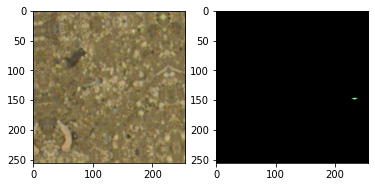

Weedelec
[0.]


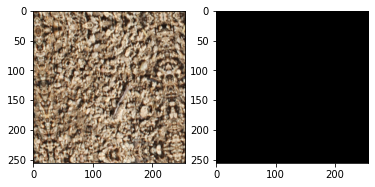

Pead
[0. 1. 2.]


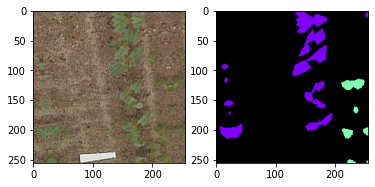

Roseau
[0. 1.]


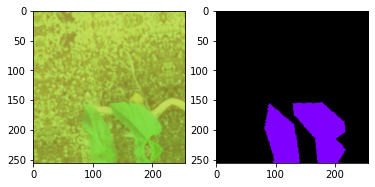

In [ ]:
for dataset_name, sets in train_datasets.items():
    print(dataset_name)

    train, valid = sets

    fig, ax = plt.subplots(1, 2)

    iterator = iter(train)

    augmented_img, target = next(iterator)
    augmented_img = augmented_img[0]   # First element
    #augmented_img = augmented_img  # denormalize
    
    target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

    print(np.unique(target))

    target_img = np.zeros([target.shape[0], target.shape[1], 3])

    target_img[np.where(target == 0)] = [0, 0, 0]
    for i in range(1, 3):
      target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

    ax[0].imshow(np.uint8(augmented_img))
    ax[1].imshow(np.uint8(target_img))

    plt.show()

# Convolutional Neural Network (CNN)

##Create model

In [ ]:
def create_model(depth, start_f, num_classes):

    return sm.Unet('resnet34', encoder_weights='imagenet', classes=num_classes, activation="softmax", input_shape=(img_h, img_w, 3))

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
    vgg.summary()
    for layer in vgg.layers:
      layer.trainable = False

    model.add(vgg)
    
    start_f = 256
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [ ]:
models = {}
for dataset_name in datasets_names:
    model = create_model(depth=5, 
                        start_f=8, 
                        num_classes=3)

    # Visualize created model as a table
    model.summary()

    # Visualize initialized weights
    # model.weights
    models[dataset_name] = model

85524480/85521592 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
___________________________

## Prepare the model for training

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

for model in models.values():
    # Compile Model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [ ]:
import os
from datetime import datetime

exps_dir = pathlib.Path('/content/drive/MyDrive/Challenge/multiclass_segmentation_experiments/')

#do_train_model = False
do_train_model = {'Pead': True,
                  'Weedelec': True,
                  'Bipbip': True,
                  'Roseau': True}

for dataset_name in models.keys():
    print("Model for %s" % dataset_name)

    model_exps_dir = exps_dir / dataset_name
    if not os.path.exists(model_exps_dir):
        os.makedirs(model_exps_dir)

    experiments = [exp for exp in os.listdir(model_exps_dir) if os.path.isdir(model_exps_dir / exp / "model")]
    last_experiment = model_exps_dir / experiments[-1] if len(experiments) > 0 else None

    if do_train_model[dataset_name] or last_experiment is None:
        if not os.path.exists(model_exps_dir):
            os.makedirs(model_exps_dir)

        now = datetime.now().strftime('%b%d_%H-%M-%S')

        model_name = 'CNN'

        exp_dir = os.path.join(model_exps_dir, model_name + '_' + str(now))
        if not os.path.exists(exp_dir):
            os.makedirs(exp_dir)
            
        callbacks = []

        # Model checkpoint
        # ----------------
        ckpt_dir = os.path.join(exp_dir, 'ckpts')
        if not os.path.exists(ckpt_dir):
            os.makedirs(ckpt_dir)

        ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                          save_weights_only=False)  # False to save the model directly
        callbacks.append(ckpt_callback)

        # Visualize Learning on Tensorboard
        # ---------------------------------
        tb_dir = os.path.join(exp_dir, 'tb_logs')
        if not os.path.exists(tb_dir):
            os.makedirs(tb_dir)
            
        # By default shows losses and metrics for both training and validation
        tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                    profile_batch=0,
                                                    histogram_freq=0)  # if 1 shows weights histograms
        callbacks.append(tb_callback)

        # Early Stopping
        # --------------
        early_stop = False
        if early_stop:
            es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=10)
            callbacks.append(es_callback)

        #models[dataset_name].fit(x=train_datasets[dataset_name][0],
        #                          epochs=1,  #### set repeat in training dataset
        #                          steps_per_epoch=len(custom_datasets[dataset_name][0]),
        #                          validation_data=train_datasets[dataset_name][1],
        #                          validation_steps=len(custom_datasets[dataset_name][1]), 
        #                          callbacks=callbacks)
        
        models[dataset_name].fit(
            train_datasets[dataset_name][0],
            steps_per_epoch=len(custom_datasets[dataset_name][0]),
            validation_data=train_datasets[dataset_name][1],
            validation_steps=len(custom_datasets[dataset_name][1]),
            epochs=1,
            callbacks=callbacks,
            use_multiprocessing=True,
            #workers=mp.cpu_count()
        )
        
        model_dir = os.path.join(exp_dir, 'model')
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        
        models[dataset_name].save(model_dir)

        # How to visualize Tensorboard

        # 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
        # 2. localhost:PORT   <- in your browser
    else:
        models[dataset_name] = tf.keras.models.load_model(str(last_experiment / "model"), custom_objects={'meanIoU': meanIoU})

Model for Bipbip
Train for 5760 steps, validate for 2880 steps
Epoch 1/3
5759/5760 [============================>.] - ETA: 0s - loss: 0.6176 - iou_score: 0.0464 - f1-score: 0.0678WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Challenge/multiclass_segmentation_experiments/Bipbip/CNN_Dec23_18-35-57/ckpts/cp_01.ckpt/assets
5760/5760 [==============================] - 1841s 320ms/step - loss: 0.6176 - iou_score: 0.0464 - f1-score: 0.0678 - val_loss: 0.6174 - val_iou_score: 0.0062 - val_f1-score: 0.0122
Epoch 2/3
5760/5760 [==============================] - 1810s 314ms/step - loss: 0.6118 - iou_score: 0.0151 - f1-score: 0.02

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Challenge/multiclass_segmentation_experiments/Bipbip/CNN_Dec23_18-35-57/model/assets
Model for Weedelec
Train for 5760 steps, validate for 2880 steps
Epoch 1/3
5760/5760 [==============================] - 1793s 311ms/step - loss: 0.6074 - iou_score: 0.0962 - f1-score: 0.1423 - val_loss: 0.6313 - val_iou_score: 0.0338 - val_f1-score: 0.0617
Epoch 2/3
5760/5760 [==============================] - 1776s 308ms/step - loss: 0.6026 - iou_score: 0.0623 - f1-score: 0.0892 - val_loss: 0.6174 - val_iou_score: 0.0243 - val_f1-score: 0.0451
Epoch 3/3
5760/5760 [==============================] - 1785s 310ms/step - loss: 0.6015 - iou_score: 0.0621 - f1-score: 0.0841 - val_loss: 0.6215 - val_iou_score: 0.0293 - val_f1-score: 0.0537


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Challenge/multiclass_segmentation_experiments/Weedelec/CNN_Dec23_20-07-18/model/assets
Model for Pead
Train for 5760 steps, validate for 2880 steps
Epoch 1/3
5760/5760 [==============================] - 1807s 314ms/step - loss: 0.6606 - iou_score: 0.0735 - f1-score: 0.1180 - val_loss: 0.6635 - val_iou_score: 0.0268 - val_f1-score: 0.0472
Epoch 2/3
5760/5760 [==============================] - 1784s 310ms/step - loss: 0.6502 - iou_score: 0.0462 - f1-score: 0.0769 - val_loss: 0.6633 - val_iou_score: 0.0144 - val_f1-score: 0.0239
Epoch 3/3
5760/5760 [==============================] - 1784s 310ms/step - loss: 0.6470 - iou_score: 0.0394 - f1-score: 0.0657 - val_loss: 0.6586 - val_iou_score: 0.0140 - val_f1-score: 0.0230


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Challenge/multiclass_segmentation_experiments/Pead/CNN_Dec23_21-36-53/model/assets
Model for Roseau
Train for 5760 steps, validate for 2880 steps
Epoch 1/3
2200/5760 [==========>...................] - ETA: 16:03 - loss: 0.6554 - iou_score: 0.1359 - f1-score: 0.1950Buffered data was truncated after reaching the output size limit.

#Test model

##Prepare Test Dataset

In [ ]:
test_dir = dataset_folder / "Test_Dev"

test_datasets_paths = {}
for dataset_name in datasets_names:
    path = test_dir / dataset_name
    path_Haricot = path / "Haricot"
    path_Mais = path / "Mais"

    test_datasets_paths[dataset_name] = [path,
                                         path_Haricot,
                                         path_Mais]

test_datasets_paths

{'Bipbip': [PosixPath('/content/Development_Dataset/Test_Dev/Bipbip'),
  PosixPath('/content/Development_Dataset/Test_Dev/Bipbip/Haricot'),
  PosixPath('/content/Development_Dataset/Test_Dev/Bipbip/Mais')],
 'Pead': [PosixPath('/content/Development_Dataset/Test_Dev/Pead'),
  PosixPath('/content/Development_Dataset/Test_Dev/Pead/Haricot'),
  PosixPath('/content/Development_Dataset/Test_Dev/Pead/Mais')],
 'Roseau': [PosixPath('/content/Development_Dataset/Test_Dev/Roseau'),
  PosixPath('/content/Development_Dataset/Test_Dev/Roseau/Haricot'),
  PosixPath('/content/Development_Dataset/Test_Dev/Roseau/Mais')],
 'Weedelec': [PosixPath('/content/Development_Dataset/Test_Dev/Weedelec'),
  PosixPath('/content/Development_Dataset/Test_Dev/Weedelec/Haricot'),
  PosixPath('/content/Development_Dataset/Test_Dev/Weedelec/Mais')]}

In [ ]:
#delete the splits of the previous run
do_clear_test_splits = True

if do_clear_test_splits:
    for _, path_Haricot, path_Mais in test_datasets_paths.values():
        delete_previous_Splits(path_Haricot)
        delete_previous_Splits(path_Mais)

In [ ]:
def test_slicing(dataset_path):
    path_tiles = dataset_path / "Tiles"
    path_tiles_images = path_tiles / "Images" 

    path_images = dataset_path / "Images" 

    if not os.path.exists(path_tiles):
        os.makedirs(path_tiles)
        os.makedirs(path_tiles_images)

    print("Slicing from %s" % path_images)

    image_filenames = next(os.walk(path_images))[2]

    for row_index, image_name in enumerate(tqdm(image_filenames, file=sys.stdout)):   

        image = Image.open(path_images / image_name).resize((2048, 1536))
        n_split_1 = int(image.size[1] / 256)
        n_split_2 = int(image.size[0] / 256)

        rgb_tensor = tf.convert_to_tensor(np.array(image))
        output = tf.split(rgb_tensor, n_split_1, axis=0)

        for i ,verticalSlice in enumerate(output):
            horizontalSlice = tf.split(verticalSlice, n_split_2, axis=1)

            for j,tile in enumerate(horizontalSlice):
                file_name = os.path.splitext(image_name)[0]
                Image.fromarray(tile.numpy()).save(path_tiles_images / (file_name + '_' + str(i) + '_' + str(j) + ".png"))

In [ ]:
if do_clear_test_splits:
    for dataset_name, paths in test_datasets_paths.items():
        print(dataset_name)

        for path in paths[1:]:
            test_slicing(path)


Bipbip
Slicing from /content/Development_Dataset/Test_Dev/Bipbip/Haricot/Images
100%|██████████| 15/15 [00:13<00:00,  1.14it/s]
Slicing from /content/Development_Dataset/Test_Dev/Bipbip/Mais/Images
100%|██████████| 15/15 [00:12<00:00,  1.22it/s]
Weedelec
Slicing from /content/Development_Dataset/Test_Dev/Weedelec/Haricot/Images
100%|██████████| 15/15 [00:19<00:00,  1.28s/it]
Slicing from /content/Development_Dataset/Test_Dev/Weedelec/Mais/Images
100%|██████████| 15/15 [00:20<00:00,  1.36s/it]
Pead
Slicing from /content/Development_Dataset/Test_Dev/Pead/Haricot/Images
100%|██████████| 15/15 [00:15<00:00,  1.02s/it]
Slicing from /content/Development_Dataset/Test_Dev/Pead/Mais/Images
100%|██████████| 15/15 [00:15<00:00,  1.00s/it]
Roseau
Slicing from /content/Development_Dataset/Test_Dev/Roseau/Haricot/Images
100%|██████████| 15/15 [00:23<00:00,  1.56s/it]
Slicing from /content/Development_Dataset/Test_Dev/Roseau/Mais/Images
100%|██████████| 15/15 [00:24<00:00,  1.62s/it]


##Compute predictions

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

Bipbip


(1, 256, 256, 3)

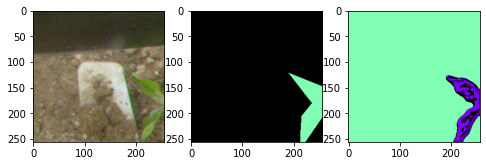

Weedelec


(1, 256, 256, 3)

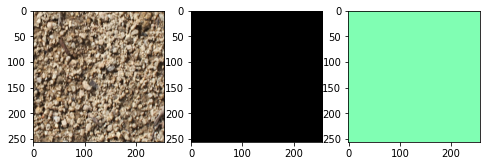

Pead


(1, 256, 256, 3)

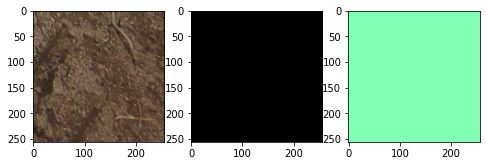

Roseau


(1, 256, 256, 3)

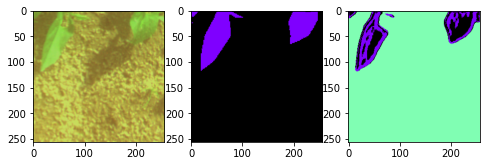

In [ ]:
for dataset_name, sets in train_datasets.items():
    print(dataset_name)
    fig, ax = plt.subplots(1, 3, figsize=(8, 8))

    iterator = iter(sets[1])

    image, target = next(iterator)

    image = image[0]
    target = target[0, ..., 0]

    out_sigmoid = models[dataset_name].predict(x=tf.expand_dims(image, 0))

    # Get predicted class as the index corresponding to the maximum value in the vector probability
    # predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
    # predicted_class = predicted_class[0, ..., 0]
    predicted_class = tf.argmax(out_sigmoid, -1)

    out_sigmoid.shape

    predicted_class = predicted_class[0, ...]

    # Assign colors (just for visualization)
    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

    target_img[np.where(target == 0)] = [0, 0, 0]
    for i in range(1, 3):
      target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

    prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
    for i in range(1, 3):
      prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

    ax[0].imshow(np.uint8(image))
    ax[1].imshow(np.uint8(target_img))
    ax[2].imshow(np.uint8(prediction_img))

    plt.show()
    time.sleep(1)

##Encode Predictions

In [ ]:
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def read_rgb_mask(mask_img):
    '''
    mask_img: mask image
    Returns the numpy array containing target values
    '''

    #mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
def add_image_to_submission(mask_arr, submission_dict, img_name, team_, crop_):

    # load mask <- HERE you should have your segmentation model instead
    #mask_arr = np.load('./predictions/arr_mask_example.npy')
    
    submission_dict[img_name] = {}
    submission_dict[img_name]['shape'] = mask_arr.shape
    submission_dict[img_name]['team'] = team_
    submission_dict[img_name]['crop'] = crop_
    submission_dict[img_name]['segmentation'] = {}

    # RLE encoding
    # crop
    rle_encoded_crop = rle_encode(mask_arr == 1)
    # weed
    rle_encoded_weed = rle_encode(mask_arr == 2)

    submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
    submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

    return submission_dict

In [ ]:
def rle_and_add_image_to_submission(prediction_image, submission_dict, img_name, team_, crop_):
    new_mask_arr = read_rgb_mask(prediction_image)
    submission_dict = add_image_to_submission(new_mask_arr, submission_dict, img_name, team_, crop_)
    return submission_dict

##Compute Predictions

In [ ]:
from PIL import Image

colors_dict = {}
colors_dict[0] = [0, 0, 0]  # background
colors_dict[1] = [255, 255, 255]  # crop
colors_dict[2] = [216, 67, 82]  # weed

In [ ]:
def do_prediction(directory_with_images, submission_dict, team_, crop_):

    for dirname, _, imageFilenames in os.walk(directory_with_images):
        for imageFilename in tqdm(imageFilenames, file=sys.stdout):

            img = Image.open(directory_with_images / imageFilename).convert('RGB')
            img_size = img.size
            img = img.resize((2048,1536))

            rgb_tensor = tf.convert_to_tensor(np.array(img))
            n_split_1 = int(img.size[1] / 256)
            n_split_2 = int(img.size[0] / 256)

            output = tf.split(rgb_tensor, n_split_1, axis=0)

            vertical_prediction = []

            for i ,verticalSlice in enumerate(output):

                horizontalSlice = tf.split(verticalSlice, n_split_2, axis=1)
                
                horizontal_prediction = []

                for j,tile in enumerate(horizontalSlice):

                    imgArray = tile.numpy()
                    imgArray = np.expand_dims(imgArray, 0)
                    out_sigmoid = models[team].predict(imgArray)
                    out_sigmoid = np.transpose(out_sigmoid, (0, 2, 1, 3))
                    horizontal_prediction.append(out_sigmoid)
                
                vertical_prediction.append(tf.concat(horizontal_prediction,axis=1))
            
            predicted_class = tf.concat(vertical_prediction,axis=2)
            predicted_class = tf.argmax(predicted_class, -1)
            predicted_class = predicted_class[0, ...]
            predicted_class = np.transpose(predicted_class)

            prediction_img = np.zeros(([img.size[1],img.size[0], 3]))
            prediction_img[np.where(predicted_class == 0)] = colors_dict[0]
            prediction_img[np.where(predicted_class == 1)] = colors_dict[1]
            prediction_img[np.where(predicted_class == 2)] = colors_dict[2]

            prediction_img = np.uint8(prediction_img)
            prediction_img = Image.fromarray(prediction_img, 'RGB').resize(img_size, resample=Image.NEAREST)
            prediction_img = np.array(prediction_img)
            
            plt.imshow(np.uint8(prediction_img))
            plt.plot()

            # Get name only
            img_name = os.path.splitext(imageFilename)[0]

            submission_dict = rle_and_add_image_to_submission(prediction_img, submission_dict, img_name, team_, crop_)
            
    return submission_dict

In [ ]:
submission_dict = {}

print("Prediction started")

for team in datasets_names:
    for crop in ["Haricot", "Mais"]:
        directory_with_images = test_datasets_paths[team][1 if crop is "Haricot" else 2] / "Images"
        
        submission_dict = do_prediction(directory_with_images, submission_dict, team, crop)

print("Prediction finished")

#Writing to file

In [ ]:
out_folder = pathlib.Path('/content/drive/MyDrive/Challenge/out')

if not os.path.isdir(out_folder):
    os.makedirs(out_folder)

out_file = out_folder / "submission.json"

out_zip = out_folder / "submission.zip"

def create_submission_file(submission_dict):
    # Finally, save the results into the submission.json file
    with open(out_file, 'w+') as f:
        json.dump(submission_dict, f)
    
    if os.path.isfile(out_zip):
        os.remove(out_zip)
    
    !cp /content/drive/MyDrive/Challenge/out/submission.json .
    !zip /content/drive/MyDrive/Challenge/out/submission.zip ./submission.json
    !rm ./submission.json

In [ ]:
#print(submission_dict.items())

create_submission_file(submission_dict)